In [17]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [18]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import seaborn as sns

In [19]:
from models import *

In [20]:
from tqdm import tqdm_notebook as tqdm

# BilinearSampler Test Field

In [ ]:
def mesh(H, W):
    x, y= torch.arange(W), torch.arange(H)
    x = x.unsqueeze(0).repeat(H, 1)
    y = y.unsqueeze(1).repeat(1, W)
    xy = torch.stack((x/((W-1)/2)-1, y/((H-1)/2)-1 ), -1)
    return xy


In [ ]:
pimg = plt.imread('img/donald-trump-threatens-ex-obama-officials.jpg')
plt.imshow(pimg); plt.show()

In [ ]:
pimg = pimg[100:400, 150:450]
plt.imshow(pimg); plt.show()

In [ ]:
timg = torch.from_numpy(pimg).type(torch.FloatTensor).permute(2,0,1)

pimg[:,:,0] - timg[0] 

## Creat the Mesh

In [ ]:
xy = mesh(300,300); xy.shape

In [ ]:
simg = F.grid_sample( timg.unsqueeze(0), xy.unsqueeze(0))

In [ ]:
(torch.abs(timg-simg.data)).sum()

In [ ]:
plt.imshow(simg.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()

## Funny Flip

In [ ]:
xy[0,0], xy[-1, -1]
x, y = xy[:,:,0], xy[:,:,1]
xy = torch.stack((y,x),-1)

In [ ]:
simg = F.grid_sample( timg.unsqueeze(0), xy.unsqueeze(0))

In [ ]:
plt.imshow(simg.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()

## Test it with all zero (just sample the middle)

In [ ]:
zeros = torch.zeros_like(xy.unsqueeze(0))

In [ ]:
simg = F.grid_sample( timg.unsqueeze(0), zeros)

In [ ]:
plt.imshow(simg.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()

In [ ]:
from models import BilinearProj

In [ ]:
sampler = BilinearProj()

In [ ]:
def mesh2(H, W):
    x, y= torch.arange(W), torch.arange(H)
    x = x.unsqueeze(0).repeat(H, 1)
    y = y.unsqueeze(1).repeat(1, W)
    #xy = torch.stack((x/((W-1)/2)-1, y/((H-1)/2)-1 ), -1)
    return x, y

In [ ]:
x.shape

In [ ]:
x, y= mesh2(300,300)
sampled = sampler(timg.unsqueeze(0), x.unsqueeze(0), y.unsqueeze(0))

In [ ]:
plt.imshow(sampled.squeeze(0).permute(1,2,0).data.numpy()/255 ); plt.show()

In [ ]:
H, W = 30, 30

In [ ]:
offset = Offset()

In [ ]:
EPS = 1e-10

In [ ]:
pose = V(torch.zeros(1,6)) + EPS

In [ ]:
inv_depth = V(torch.ones(1, 1, H, W))

In [ ]:
camera = V(torch.FloatTensor(np.array([372.106469,368.444783,314.357737,88.265872]))).view(1, -1)

In [ ]:
tx, ty, dmask= offset.forward(pose, inv_depth, camera)

In [ ]:
tx.shape

In [ ]:
tx[0,:3, :3]

In [ ]:
ty[0,:3, :3]

In [ ]:
dmask[0,:3, :3]

In [ ]:
torch.sin(torch.FloatTensor([3.14/2]))

In [ ]:
pose = V(torch.FloatTensor(np.array((EPS, EPS, 3.14/2, 0, 0, 0))).view(1, -1))

In [ ]:
tx, ty, dmask= offset.forward(pose, inv_depth, camera)

In [ ]:
ty[0, :3, :3]

In [ ]:
tx[0, :3, :3]

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
class Twist2Mat(nn.Module):
    def __init__(self):
        super(Twist2Mat, self).__init__()
        self.register_buffer('o', torch.zeros(1,1))
        self.register_buffer('E', torch.eye(3))

    def cprodmat_batch(self, a_batch):
        batch_size, _ = a_batch.size()
        o = Variable(self.o).expand(batch_size, 1)
        a0 = a_batch[:, 0:1]
        a1 = a_batch[:, 1:2]
        a2 = a_batch[:, 2:3]
        return torch.cat((o, -a2, a1, a2, o, -a0, -a1, a0, o), 1).view(batch_size, 3, 3)

    def forward(self, twist_batch):
        batch_size, _ = twist_batch.size()
        rot_angle = twist_batch.norm(p=2, dim=1).view(batch_size, 1).clamp(min=1e-5)
        # rot_axis = twist_batch / rot_angle.expand(batch_size, 3)
        rot_axis = twist_batch / rot_angle
        A = self.cprodmat_batch(rot_axis)
        return Variable(self.E).view(1, 3, 3).expand(batch_size, 3, 3)\
            + A*rot_angle.sin().view(batch_size, 1, 1).expand(batch_size, 3, 3)\
            + A.bmm(A)*((1-rot_angle.cos()).view(batch_size, 1, 1).expand(batch_size, 3, 3))

In [ ]:
type(pose)

In [ ]:
t2m = Twist2Mat().cuda()

In [ ]:
type(t2m.E) 

In [ ]:
t2m(pose)

In [ ]:
pose.size()

In [ ]:
rot_vec = pose[:, :3]
offset.rot_vec2mat(rot_vec)

In [ ]:
x, y = mesh2(H, W)


In [ ]:
# equvalent statement! but the one below save computation
xyz = R_batch[:, :, 0:2].bmm(xy.view(1, 2, N).expand(batch_size, 2, N))\
    + R_batch[:, :, 2:3].expand(batch_size, 3, N)\
    + t_batch.view(batch_size, 3, 1).expand(batch_size, 3, N) * inv_depth.view(-1, 1, N).expand(batch_size, 3, N)
z = xyz[:, 2:3, :].clamp(min=1e-10)
xy_warp = xyz[:, 0:2, :] / z.expand(batch_size, 2, N)
# u_warp = ((xy_warp[:, 0, :]*self.camparams['fx'] + self.camparams['cx'])/2**level_idx - .5).view(batch_size, N)
# v_warp = ((xy_warp[:, 1, :]*self.camparams['fy'] + self.camparams['cy'])/2**level_idx - .5).view(batch_size, N)
# print(self.x_pyramid[level_idx][0])
u_warp = ((xy_warp[:, 0, :] * self.camparams['fx'] + self.camparams['cx']) - getattr(self, 'x_'+str(level_idx))[0]).view(
    batch_size, N) / 2 ** level_idx
v_warp = ((xy_warp[:, 1, :] * self.camparams['fy'] + self.camparams['cy']) - getattr(self, 'y_'+str(level_idx))[0]).view()/2 ** level_idx


# testing the loss function

## SSIM loss test

In [ ]:
pimg = plt.imread('img/donald-trump-threatens-ex-obama-officials.jpg')
plt.imshow(pimg); plt.show()

In [ ]:
timg = torch.from_numpy(pimg).type(torch.FloatTensor).permute(2,0,1)/255.0
timg = timg.unsqueeze(0).cuda()
noise = torch.randn(timg.size()).cuda()

# the mask is to simulate the actual usage where some part is get screened.
mask = torch.zeros_like(timg)
b, c, h, w = timg.shape
mask[:, :, h//5:h//5*4, w//5: w//5*4 ] = 1
timg = timg*mask
noise = noise*mask

mask = V(mask)
timg = V(timg)
noise = Variable(noise, requires_grad=True)
#noise = nn.Parameter(noise)


In [ ]:
# import it from models
# import pytorch_ssim

verbose = 200
count = 0

# Functional: pytorch_ssim.ssim(img1, img2, window_size = 11, size_average = True)
#ssim_value = pytorch_ssim.ssim(timg, noise).data[0]
ssim_loss = SSIM()
ssim_value = ssim_loss(timg, noise, mask).data[0]
print("Initial ssim:", ssim_value)

# Module: pytorch_ssim.SSIM(window_size = 11, size_average = True)
#ssim_loss = pytorch_ssim.SSIM()

optimizer = optim.Adam([noise], lr=0.01)

while ssim_value < 0.98:
    count += 1
    if count % verbose == 0:
        print(ssim_value)
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()
    optimizer.zero_grad()
    ssim_out = -ssim_loss(timg, noise, mask)
    ssim_value = - ssim_out.data[0]
    #print(ssim_value)
    ssim_out.backward()
    optimizer.step()
    
plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
plt.show()  
    

In [ ]:
opt = optim.Adam([noise], lr=0.01)

for i in range(3000):
    opt.zero_grad()
    loss = compute_SSIM( noise, timg).mean()

    #loss = ssim_loss( noise, V(timg), V(mask) )
    loss.backward()
    opt.step()
    if i % 150 == 0:
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()

In [ ]:
from models import *

opt = optim.Adam([noise], lr=0.01)

for i in range(1000):
    opt.zero_grad()
    loss = l1_loss( noise, V(timg), V(mask) )
    loss.backward()
    opt.step()
    if i % 150 == 0:
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()

# Test Smooth Loss

In [ ]:
noise = (torch.randn((3,256,256)) + torch.ones((3,256,256))).cuda()
noise = noise.unsqueeze(0)
noise = Variable(noise, requires_grad=True)
#noise = nn.Parameter(noise)

In [ ]:
l = SmoothLoss()

In [ ]:
opt = optim.Adam([noise], lr=0.1)

for i in range(1000):
    opt.zero_grad()
    loss = l(noise)
    loss.backward()
    opt.step()
    if i % 150 == 0:
        plt.imshow(noise.cpu().data[0].permute(1,2,0).numpy());
        plt.show()

# Wrap Function Test

In [86]:
ssim_loss = SSIM()

In [116]:
train, val= pd.read_csv('./KITTI/training_192_640_pre.csv'), pd.read_csv('./KITTI/validation_192_640_pre.csv')

In [117]:
index = train.sample(1).index[0]
img1 , img2 = train.loc[index,'t0'], train.loc[index,'t1']

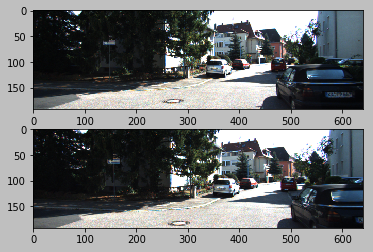

In [118]:
img1, img2 = plt.imread('./KITTI/'+img1), plt.imread('./KITTI/'+img2)
fig, axs = plt.subplots(2,1)
axs[0].imshow(img1)
axs[1].imshow(img2)
plt.show()

In [119]:
img1 = torch.from_numpy(img1 ).permute(2,0,1).unsqueeze(0).contiguous() 
img2 =  torch.from_numpy( img2 ).permute(2,0,1).unsqueeze(0).contiguous() 

In [191]:
trans = Variable( torch.randn(1,3).cuda() * 0.001, requires_grad=True )
rot = Variable( torch.randn(1,3).cuda() * 0.01, requires_grad=True )

scale = 0
b, c, h, w = img1.size()
depth = Variable( torch.ones(b, c, h//2**scale, w//2**scale).cuda(), requires_grad=True )

#depth = Variable( torch.randn(img1.size()).cuda(), requires_grad=True )

camera = V(torch.FloatTensor([370.454846,366.80941,309.62854,92.687081]).cuda().unsqueeze(0))

In [192]:
trans.requires_grad

True

In [193]:
depth.mean(), depth.std()

(Variable containing:
  1
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [194]:
offset = Offset3().cuda()
sampler = BilinearProj().cuda()
smooth  = SmoothLoss()

In [195]:
losses = []

In [196]:
opt = optim.Adam([trans, rot], lr=0.001)
opt2 = optim.Adam([depth], lr=.01)
for i in tqdm(range(1000)):
    
    opt.zero_grad()
    opt2.zero_grad()

    if scale>0:
        updepth = F.upsample(input=depth, scale_factor=2**scale, mode='bilinear')
    else:
        updepth = depth    
    
    inv_depth = F.sigmoid(updepth) * 10 + 0.01
    cx12, cy12, d_mask12 = offset.forward(trans, rot, inv_depth = inv_depth, camera = camera)
    x12, in_mask12 = sampler.forward(V(img1), cx12, cy12)

    #m = (d_mask12*in_mask12).unsqueeze(1)     
    m = d_mask12.unsqueeze(1)
    
#     loss = .15*l1_loss( V(img2), x12, m) + .85*ssim_loss( V(img2), x12, m) #+ smooth(inv_depth) * 10
    loss = .85*l1_loss( V(img2), x12, m) + .15*ssim_loss( V(img2), x12, m) #+ smooth(inv_depth) * 10
#     loss = .85*l1_loss( V(img2), x12, m)
    #loss = ssim_loss( V(img2), x12, m )
    #loss += .15*ssim_loss( V(img2), x12, m) 
    loss += smooth(inv_depth) * 50
    losses.append(loss.data[0])
    loss.backward()
    opt.step()
    opt2.step()

In [197]:
loss

Variable containing:
1.00000e-02 *
  6.1611
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [198]:
rot

Variable containing:
1.00000e-03 *
  7.6316 -3.6818 -0.8698
[torch.cuda.FloatTensor of size 1x3 (GPU 0)]

In [199]:
trans

Variable containing:
1.00000e-03 *
 -4.3660 -1.0201  5.4912
[torch.cuda.FloatTensor of size 1x3 (GPU 0)]

In [200]:
inv_depth.mean(), inv_depth.std(), inv_depth.min(), inv_depth.max()

(Variable containing:
  7.3351
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 1.00000e-02 *
   8.6654
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  5.9359
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  9.3581
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [183]:
def plot_img(recon, index=0, figsize=(12,4)):
    recon = recon[index].permute(1,2,0).numpy()
    plt.figure(figsize=figsize)
    plt.imshow(recon)
    plt.axis('off')    

In [184]:
def plot_depth(depth, index=0, figsize=(12,4), scale=50, inv=True):
    inv_depth = depth.cpu().data[index].numpy()
    inv_depth = np.clip(inv_depth, a_min=0.01, a_max=None)
    if inv:
        depth = 1/inv_depth[0]
    else:
        depth = inv_depth[0]
        
    m, std, mx = depth.mean(axis=(0, 1)), depth.std(axis=(0, 1)), depth.max(axis=(0, 1))
    plt.figure(figsize=figsize)
    plt.imshow(
        depth*scale,
        cmap = "gray"
        #cmap="viridis",
        #vmin=max(m - 2*std, 0),
        #vmax=min(m+2*std, mx)
    )
    plt.colorbar()
    plt.axis('off')

In [185]:
def plot_mask(mask, index=0, figsize=(12,4)):
    plt.style.use('grayscale')
    mask = mask[index]
    plt.figure(figsize=figsize)
    plt.imshow(mask.cpu().data.numpy(),cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    plt.axis('off')

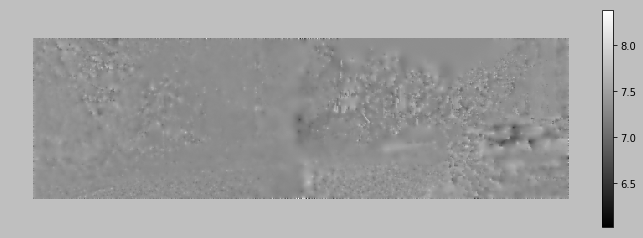

In [205]:
plot_depth(inv_depth, index=0, scale=1,inv=False)

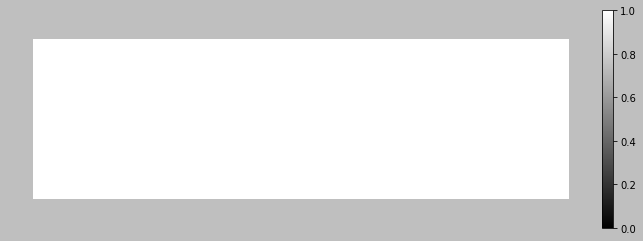

In [187]:
plot_mask(d_mask12, index=0)

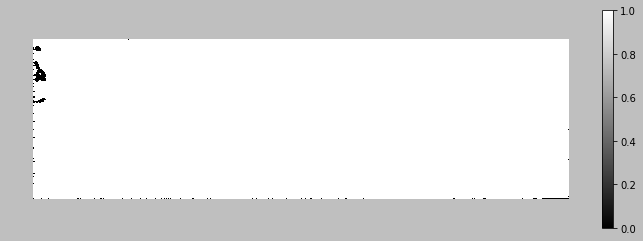

In [188]:
plot_mask(in_mask12, index=0)

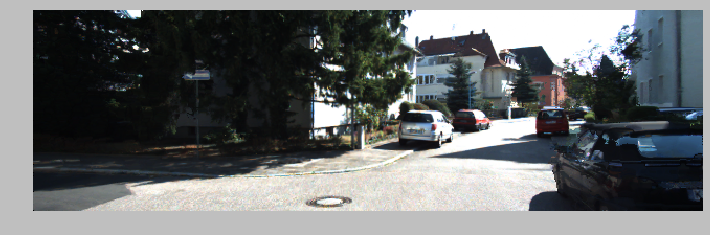

In [202]:
plot_img(x12.cpu().data)

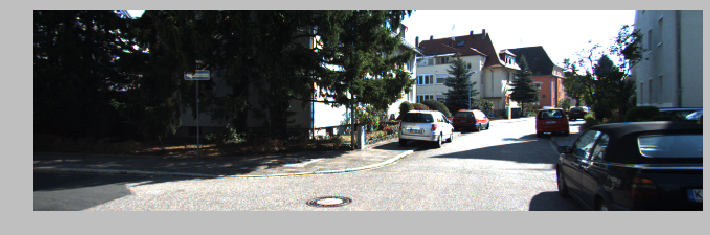

In [203]:
plot_img(img2)

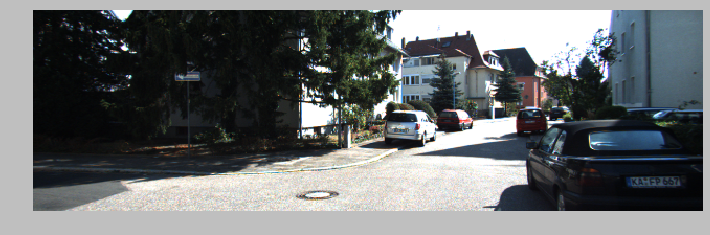

In [172]:
plot_img(img1)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


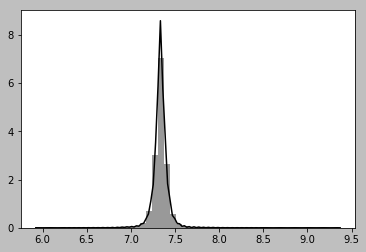

In [204]:
sns.distplot(inv_depth.cpu().data.view(-1).numpy())

# Percetual Loss

In [ ]:
from scipy import ndimage

In [ ]:
f

In [ ]:
rn = f(False)
layers = children(rn); 
layers = layers[:5]
layers

In [ ]:
pc = nn.Sequential(*layers)

In [ ]:
pc= pc.cuda()
pc.eval()
set_trainable(pc, False)

In [ ]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
pc= nn.Sequential(*children(m_vgg)[:37])

In [ ]:
def pl(x1, x2):
    res1= pc(x1)
    res2 = pc(x2)
    return F.mse_loss(res1, res2)

In [ ]:
pimg = open_image('img/donald-trump-threatens-ex-obama-officials.jpg')
plt.imshow(pimg); plt.show()

In [ ]:
sz = 288
trn_tfms, val_tfms = tfms_from_model(f, sz)
timg = val_tfms(pimg)
timg.shape
timg_v = V(timg[None])

In [ ]:
noise = np.random.uniform(0,1, size=pimg.shape)
noise = scipy.ndimage.filters.median_filter(noise, [8,8,1])

In [ ]:
noise = val_tfms(noise)/2
noise_v = V(noise[None], requires_grad=True)
noise_v.shape

In [ ]:
pl(timg_v, noise_v)

In [ ]:
verbose = 100
count = 0
#optimizer = optim.LBFGS([noise_v], lr=0.5)
#optimizer = optim.SGD([noise_v], lr = 0.001, momentum=0.8 )
optimizer = optim.Adam([noise_v], lr=0.1)

for i in range(1000):
    count += 1
    if count % verbose == 0:
        plt.imshow(noise_v.cpu().data[0].permute(1,2,0).numpy());
        plt.show()
    optimizer.zero_grad()
    loss = pl(timg_v, noise_v)
    loss_value = loss.data[0]
    #print(loss_value)
    loss.backward()
    optimizer.step()
    
plt.imshow(noise_v.cpu().data[0].permute(1,2,0).numpy());
plt.show()  
    

In [ ]:
?? get_base

In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.perceptor = get_base(f, 2)
        
    def forward(self, x1, x2):
        return torch.mse(self.perceptor(x1)-self.perceptor(x2))